In [1]:

# Reloading
%reload_ext autoreload
%autoreload 2

import pandas as pd
print('pandas version:{}'.format(pd.__version__))
import numpy as np
print('numpy version:{}'.format(np.__version__))
import math
from datetime import datetime
from dgpylib import dg_athena
from dgpylib import dg_s3
import os
import re
from matplotlib.ticker import MaxNLocator
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import sys
sys.path.insert(0, '../Modelling')
import helper_function2 as hf

import sys
sys.path.insert(0, '../EDA')
import data_integrity_fixer as dint
import basicstatsandplotter as bsp
import data_imputer as di
import data_integrity_fixer as dif
import parameters

##for modelling
import h2o
print('h2o version:{}'.format(h2o.__version__))
from h2o.estimators import H2OXGBoostEstimator
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OTargetEncoderEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators import H2OGradientBoostingEstimator
from h2o.tree import H2OTree
from h2o.tree import H2ONode
from h2o.tree import H2OSplitNode
from h2o.tree import H2OLeafNode
from h2o.estimators.kmeans import H2OKMeansEstimator

#import xgboost as xgb
import sklearn
import category_encoders as ce
print('sklearn version:{}'.format(sklearn.__version__))
from sklearn import datasets
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score
from sklearn.preprocessing import PowerTransformer
import time
import parameters
from statsmodels.stats.outliers_influence import variance_inflation_factor

%run 'functions.ipynb'

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100

pandas version:1.3.4
numpy version:1.20.3
h2o version:3.36.0.4
sklearn version:1.1.2


# Pre-Processing 
<a id="section1"></a>

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
conn_s3 = dg_s3.Connect('dgdatadump/DS&CA/Pricing/02 Projects/2022/Tel_Reg_2.0/Cancellation Model')
# df_raw = conn_s3.read('NewBusiness.csv')
# df_raw = conn_s3.read('NewBusiness2.csv') # inner joined with planmaster on cmk, productcode, goodscolour
df_raw = conn_s3.read('26745992-321f-4b73-b335-8a106dec2798.csv')

print(df_raw.shape)

(809833, 94)


In [4]:
df_raw.sale.value_counts()

1    410899
0    398934
Name: sale, dtype: int64

In [ ]:
# print('offereffectivedatetime:', pd.to_datetime(df_raw['offereffectivedatetime']).min(), '-', pd.to_datetime(df_raw['offereffectivedatetime']).max())
# print('planaccdate:', pd.to_datetime(df_raw['pm_planaccdate']).min(), '-', pd.to_datetime(df_raw['pm_planaccdate']).max())
# print('movementdate:', pd.to_datetime(df_raw['pm_movementdate']).min(), '-', pd.to_datetime(df_raw['pm_movementdate']).max())

In [5]:
print('offereffectivedatetime:', pd.to_datetime(df_raw['offereffectivedatetime']).min(), '-', pd.to_datetime(df_raw['offereffectivedatetime']).max())
print('planaccdate:', df_raw['pm_planaccdate'].min(), '-', df_raw['pm_planaccdate'].max())
print('movementdate:', df_raw['pm_movementdate'].min(), '-', df_raw['pm_movementdate'].max())

offereffectivedatetime: 2021-05-26 00:00:00 - 2022-09-01 00:00:00
planaccdate: 0 - 1191231
movementdate: 1050329 - 1191231


In [10]:
df = df_raw[df_raw['pm_planaccdate']>=1100101]
df = planmaster_date_to_datetime(df, ['pm_planaccdate'])

In [11]:
df['pm_planaccdate'].min()

'20100101'

In [12]:
df = planmaster_date_to_datetime(df, ['pm_movementdate'])
print('offereffectivedatetime:', pd.to_datetime(df_raw['offereffectivedatetime']).min(), '-', pd.to_datetime(df_raw['offereffectivedatetime']).max())
print('planaccdate:', df['pm_planaccdate'].min(), '-', df['pm_planaccdate'].max())
print('movementdate:', df['pm_movementdate'].min(), '-', df['pm_movementdate'].max())

offereffectivedatetime: 2021-05-26 00:00:00 - 2022-09-01 00:00:00
planaccdate: 20100101 - 20191231
movementdate: 20100324 - 20191231


## Preliminary Filters
<a id='prefilt'></a>

In [ ]:
df_raw.PeriodOfCover.describe()

In [ ]:
(df_raw['manufacturerbrandname']=='SKY').any(), (df_raw['itemgoodscategoryname']=='HEATING').any(), (df_raw.PricingVersionDescription == 'TEST').any()

In [ ]:
# # keep only POC == 12 months
# df_raw =  df_raw[df_raw['PeriodOfCover']==12]

# filter out Sky, Heating
df_raw = df_raw[(df_raw['manufacturerbrandname']!='SKY')&(df_raw['itemgoodscategoryname']!='HEATING')]
df_raw.shape

df_raw = df_raw.loc[df_raw.PricingVersionDescription != 'TEST']

In [ ]:
df_raw.groupby(['offerbusinesseventcode','requested_paymentplancode'])['requested_paymentplancode'].count()

In [ ]:
df_raw.columns.to_list()

In [ ]:
# select IPM's
df_ipm = df_raw.loc[df_raw.requested_paymentplancode=='IPM']
df_ipm.shape

In [ ]:
df = df_ipm.copy()

In [14]:
# Convert to Datetime
df['pm_planaccdate'] = pd.to_datetime(df['pm_planaccdate']) 
df['pm_movementdate'] = pd.to_datetime(df['pm_movementdate'])

# calculate contract tenure
final_date = df['pm_movementdate'].max()
df['contract_age']=np.where(df['contractstatuscode']=='C', (df['pm_movementdate']-df['pm_planaccdate'])/np.timedelta64(1, 'M'), (final_date-df['pm_planaccdate'])/np.timedelta64(1, 'M'))
# df[df['contract_age']<0].shape

In [15]:
df.loc[df['contractstatuscode']=='C', 'cancel_age'] = (df['pm_movementdate']-df['pm_planaccdate'])/np.timedelta64(1, 'M')

<AxesSubplot:>

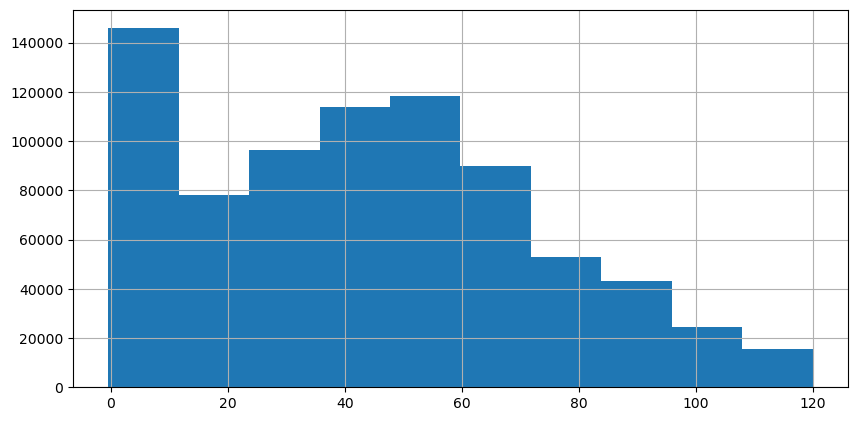

In [16]:
df['contract_age'].hist()

<AxesSubplot:>

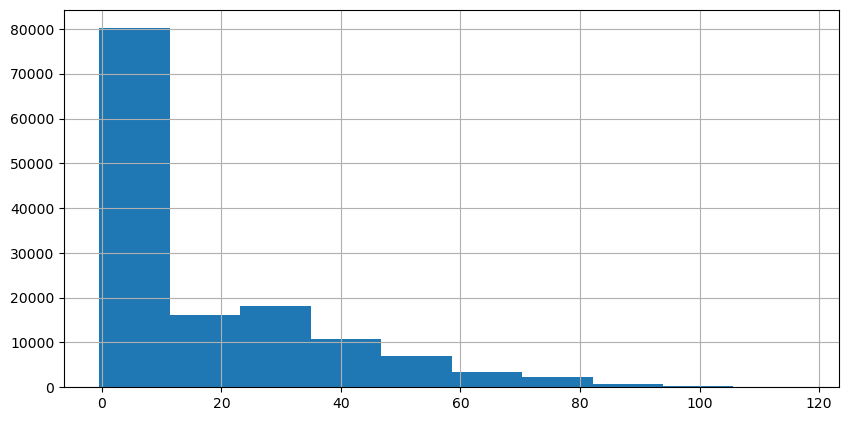

In [17]:
df['cancel_age'].hist()

In [ ]:
df.shape

In [18]:
df = df.dropna(axis=0, subset=['contractstatuscode'])
df.shape

(395031, 98)

## < 12 mo retention

In [19]:
df[[ 'itemcategoryname',
 'itemsupercategorycode',
 'itemgoodscategoryname',
 'requested_itemgoodscatcode',
 'manufacturerbrandname',
 'manufacturergroupname',
 'itemmodelnumber',
 'itempurchaseprice',
 'itempurchasedatetime',
 'itemlocationpostcode',]].head()

,itemcategoryname,itemsupercategorycode,itemgoodscategoryname,requested_itemgoodscatcode,manufacturerbrandname,manufacturergroupname,itemmodelnumber,itempurchaseprice,itempurchasedatetime,itemlocationpostcode
0,cooker,CO,WHITE,W,INDESIT,INDESIT COMPANY,NaN,369.0,2021-04-15 00:00:00.000,NG16 4GD
3,fridge freezer,RE,WHITE,W,SAMSUNG,SAMSUNG,RS68N8230B,1200.0,2019-01-02 00:00:00.000,E4 8ET
4,cooker,CO,WHITE,W,FLAVEL,FLAVEL LEISURE,NaN,400.0,2022-02-19 00:00:00.000,M23 9FP
5,fridge freezer,RE,WHITE,W,BEKO,BEKO,CXFG3691VA,450.0,2020-11-23 00:00:00.000,NP18 1AL
6,cooker,CO,WHITE,W,FLAVEL,FLAVEL LEISURE,MILANO100,750.0,2015-10-10 00:00:00.000,E8 2JW


In [20]:
# plans that went into retention within 12 months
df[(df['requested_retentionflag']==1)&(df['contract_age']<12)&(df['contractstatuscode']=='N')][['contractstatuscode',
                                                                'requested_fee',
                                                                'requested_renewalfee', 
                                                                'TotalPrice',
                                                                'gross',                                                                
                                                                'requested_itemcode', 
                                                                'requested_perpostaladdrpostcode',  
                                                                'planno',
                                                                'cocode', 
                                                                'schcode',
                                                                'requested_itemgoodscatcode',
                                                                'cmk', 'productcode', 'goodscolour','requested_itemmanufbrandcode'
                                                                ]].sort_values(by=['planno','cocode','schcode']).head(20)

,contractstatuscode,requested_fee,requested_renewalfee,TotalPrice,gross,requested_itemcode,requested_perpostaladdrpostcode,planno,cocode,schcode,requested_itemgoodscatcode,cmk,productcode,goodscolour,requested_itemmanufbrandcode
620466,N,168.00,168.00,150.24,149.90,CK,PR9 7,1,A,FPA,W,41798947,CK,W,ZANU
269790,N,93.72,93.72,83.28,61.80,LY,PL6 6,1,D,VZZ,B,696997268,LY,B,LG
648614,N,157.44,157.44,120.36,61.80,LY,PL6 6,1,D,VZZ,B,696997268,LY,B,SAMS
650865,N,157.44,157.44,120.36,61.80,LY,PL6 6,1,D,VZZ,B,696997268,LY,B,SAMS
650866,N,157.44,157.44,120.36,61.80,LY,PL6 6,1,D,VZZ,B,696997268,LY,B,SAMS
327465,N,50.40,77.88,69.96,22.50,DW,TD9 8,1,D,W11,W,636127418,DW,W,BEKO
202581,N,102.00,102.00,72.84,52.68,LY,E9 6,1,D,W6X,B,691774678,LY,B,PHIP
680970,N,110.64,110.64,98.40,129.36,CN,BR6 9,2,A,EY8,W,178795848,CN,W,SAMS
264540,N,61.44,61.44,55.32,78.00,FZ,AB42 1,4,A,F57,W,387950915,FZ,W,HOTP
630868,N,181.32,181.32,152.88,182.52,CN,WV4 4,4,A,FJX,W,280453374,CN,W,WHIR


In [ ]:
df['cmk'].head()

In [25]:
df[(df['cmk']==696997268) & (df['productcode']=='LY') & (df['goodscolour']=='B') & (df.requested_itemmanufbrandcode=='LG')][['contractstatuscode','requested_retentionflag','itempurchaseprice', 'gross', 'planno', 'cocode', 'schcode', 'pm_movementdate', 'requested_itemmanufbrandcode']].sort_values(by=['pm_movementdate'])

,contractstatuscode,requested_retentionflag,itempurchaseprice,gross,planno,cocode,schcode,pm_movementdate,requested_itemmanufbrandcode
268873,N,1,585.0,123.48,64684,A,MD3,2015-01-05,LG
268874,N,1,585.0,115.45,2568,A,ME9,2015-04-07,LG
275823,N,1,585.0,104.88,91238,A,MD3,2017-11-10,LG
271034,N,1,585.0,107.88,83295,A,MD5,2018-09-03,LG
269790,N,1,585.0,61.80,1,D,VZZ,2019-07-29,LG


In [ ]:
df[(df['planno']=='0001941') & (df['cocode']=='D') & (df['schcode']=='AWN')]

In [ ]:
df[(df['requested_retentionflag']==1)&(df['contract_age']<12)]['contractstatuscode'].value_counts()

Retention plans' status changes into New or Cancelled or Lapsed depending on the outcome of the offer

Comparing the above plans with their counterpart offers in planmaster where rec_status=0
'''select gross, planaccdate, movementdate, rec_status from "prq_datalake_11112020"."schdayfilc_planmaster" where planno='0092989' and cocode='D' and schcode='DTS''''
shows:
- cancelled plans were previously offered higher fees. 
- gross is the same as TotalPrice for retained plans but is much lower for cancelled plans
- new plans have duplicates of the same offers with same movementdate

This suggests, retained plans which become new plans have new plan number, company code & scheme code. Hence, they don't retain the price history of their predecessor unlike cancelled plans.

Next Step: Find price history for newly retained plans

In [ ]:
# check if there are missing renewal fee for validation
df[(df['requested_retentionflag']==1)&(df['contract_age']<12)]['requested_renewalfee'].isna().sum()

In [ ]:
# how many plans affected
df[(df['requested_retentionflag']==1)&(df['contract_age']<12)].shape[0], (df[(df['requested_retentionflag']==1)&(df['contract_age']<12)].shape[0])/df.shape[0]

In [ ]:
df[(df['requested_retentionflag']==1)&(df['contract_age']<12)]['price_diff'].mean()

## > 12 mo retention

In [ ]:
# plans that went into retention after 12 months

df[(df['requested_retentionflag']==1)&(df['contract_age']>=12)][['contractstatuscode','requested_fee','offeracceptedprice', 'requested_renewalfee', 'TotalPrice', 'gross', 'planno','cocode', 'schcode']].head()

In [ ]:
df[(df['requested_retentionflag']==1)&(df['contract_age']>=12)]['price_diff'].mean()

## Dedup
<a id='dedup'></a>

In [ ]:
# check duplicate offers
df_raw[df_raw.duplicated(subset='offerreferencenumber')].shape

# dedup offers
df_dedup = df_raw.drop_duplicates(subset='offerreferencenumber', keep='first')
df_dedup.shape, df_raw.shape

## Rename & Drop Columns
<a id='rename'></a>

In [ ]:
rename_list = parameters.rename_list
drop_list = parameters.drop_list

In [ ]:
df = df_dedup.copy()
df.rename(columns=rename_list, inplace=True)
df = hf.drop_columns(df, drop_list)

df.shape, df_raw.shape

## Data Formatting
<a id='form'></a>

In [ ]:
# dates

date_cols = df.columns[df.columns.str.lower().str.contains('date')]

# convert planmaster to datetime string
df = planmaster_date_to_datetime(df, columns=['planaccdate', 'movementdate']) 
date_fix(df, date_cols) # convert to datetime

print(df['CurrentDate'].min(), df['CurrentDate'].max())
print(df['movementdate'].min(), df['movementdate'].max())
print(df['planaccdate'].min(), df['planaccdate'].max())

In [ ]:
# # Convert to Int
# for col in ['ClaimPast1YearCount', 'ClaimPast3YearCount', 'ClaimPast5YearCount', 'PlanLiveCount', 'PlansAcceptedPast1YearCount', 'PlansAcceptedPast5YearCount', 'PlansActivePast1yrCount', 'PlansActivePast5yrCount', 'PlansCancelledPast1YearCount', 'PlansCancelledPast5YearCount']:
#     df[col]= df[col].astype('Int64')
    
# Convert to Datetime
# df['CurrentDate'] = pd.to_datetime(df['CurrentDate']) 
# df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

# Convert to String
for i in ['ClientGroupCode', 'ClientCode']:
    df[i] = np.where(df[i].isna(), df[i], df[i].astype('string'))
    print(i, ':', df[i].isna().sum(), df[i].dtypes)
    # print(dif.get_othernulls_count(df[i]))
# df.astype({"PmhId":str,"PerhId":str ,"ClientGroupCode": str,  "ClientCode": str})

# Create new features
df['HasPrevRTPPrice'] = np.where(df['PrevRTPPriceType'].isna(), 'N', 'Y')
df['AppAge'] = (df['CurrentDate'] - df['PurchaseDate']) / np.timedelta64(1, 'D')
# df['AppAge'] = np.where(pd.to_datetime(df['CurrentDate'])>=pd.to_datetime(df['PurchaseDate']),(pd.to_datetime(df['CurrentDate']) - pd.to_datetime(df['PurchaseDate'])) / np.timedelta64(1, 'D'), np.nan)
# df['AppAge'] = df['AppAge'].fillna(df['item_age'].mean())
df['relFee'] = df['Fee']/ df['PurchasePrice']
df['relFeeInc'] = df['price_diff']/ df['PurchasePrice']
df['PaymentType']= 'DD'

# Impute Counts in Pricing Table
to_impute = ['PlanLiveCount', 'PlansActivePast1yrCount',
       'PlansActivePast5yrCount', 'PlansAcceptedPast1YearCount',
       'PlansAcceptedPast5YearCount', 'PlansCancelledPast1YearCount',
       'PlansCancelledPast5YearCount', 'ClaimPast1YearCount',
       'ClaimPast3YearCount', 'ClaimPast5YearCount',
       'ClaimAmount1YearTotal', 'ClaimAmount3YearTotal', 'ClaimAmount5YearTotal']

df[to_impute] = df[to_impute].fillna(0)


In [ ]:
# convert count columns to integer
count_cols = list(df.columns[df.columns.str.lower().str.contains('count')])
count_cols

In [ ]:
count_cols.remove('ClientAccountDesc')
df[count_cols] = df[count_cols].astype(int)
df[count_cols].info()

In [ ]:
df = hf.drop_columns(df, drop_list)

## Basic Statistics
<a id='stats'></a>

In [ ]:
#dtypes
x= df.dtypes.to_frame().reset_index()
x.columns = ['ColName', 'dtype']
x= x.sort_values(by= 'ColName')

#missing
y= df.isna().sum().to_frame().reset_index()
y.columns = ['ColName', 'Na_rows']
y= y.sort_values(by= 'ColName')

#describe
d= df.describe(percentiles= [.1, .9, .95, .975]).T.reset_index()
d.columns = ['ColName', 'count', 'mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max']
d= d.sort_values(by= 'ColName')

#join
z= x.merge(y, on= 'ColName', how= 'left').merge(d, on='ColName', how= 'left')
z['N'] = df.shape[0]
z['Na_miss_rate'] = (z['Na_rows'] / z['N']) * 100

z['dtype'] = z['dtype'].astype('str')

fltr= z['dtype'].isin(['float64'])
z.style.format('{:,.2f}', subset=['mean', 'std', 'min', '10%', '50%', '90%', '95%', '97.5%', 'max', 'Na_miss_rate']).format('{:,.0f}', subset=['N', 'Na_rows', 'count'])

## Single Value & Null Columns
<a id='singlenull'></a>

In [ ]:
# split columns by type
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df)

# count unique values
feature_uniques_count, low_cardinality_features_unique_values= bsp.unique_count(df[categorical_cols])

# Single value categorical columns
single_val = list([key for key, value in feature_uniques_count.items() if value == 1 ])
single_val.remove('PaymentType')

#drop single value categorical cols
df = hf.drop_columns(df, single_val)

# drop single value numerical columns
df = hf.drop_columns(df,['rec_status', 'PredictedConversionRate'])

# null columns
na_count = df.apply(dint.get_nulls_count)
null_cols = na_count[na_count.values>=80].index
null_cols

# drop cols with >80% nulls
df = hf.drop_columns(df, null_cols)

## Categorical Features
<a id='catfeat'></a>

In [ ]:
# reduce cardinality of certain categorical features

cat_features = [f for f in df.select_dtypes(include=['object']).columns.sort_values() if f not in ['CurrentDate', 'PurchaseDate', 'ons_postcode_sector', 'PerPostalAddrPostCode', 'RouteToMarketName', 'PrevRTPPriceType', 'SchemeTypeName', 'planaccdate', 'movementdate']]
id_cols = ['offerreferencenumber', 'itemeventuserid', 'ModelId']
postcode_cols = ['personaddresspostcode', 'offerpostcode', 'Postcode_Sector']

In [ ]:
to_group = list(set(cat_features) - set(id_cols) - set(postcode_cols))
for i in to_group:
    print(f'{i}:{df[i].nunique()}')

In [ ]:
group_low_freq(df=df, lst= to_group, pct=2.5) # regroup very low frequency classes
for i in to_group:
    print(f'{i}:{df[i].nunique()}')

In [ ]:
df_dedup[df_dedup['requested_clientaccountdesc']=='HSBC'].shape[0]/df_dedup.shape[0]

In [ ]:
df[df['ClientAccountDesc']=='HSBC'].shape[0]

In [ ]:
categorical_cols, integer_cols, float_cols, date_cols, unidentified_cols = hf.cat_num_split(df)
categorical_cols

In [ ]:
#strip whitespace in categorical columns
for i in list(set(categorical_cols) - set(date_cols)):
    if (df[i].isna().any()):
        break
    print(i)
    df[i] = df[i].apply(lambda x: str(x).replace(" ", "").upper())

# find na's
cat_nulls = df[categorical_cols].apply(dint.get_nulls_count)
cat_to_impute = list(cat_nulls[cat_nulls.values>0].index)

# impute na's
df[cat_to_impute]=df[cat_to_impute].apply(lambda x: x.fillna(x.mode().iloc[0]))

In [ ]:
df['Postcode_Sector'] = df['Postcode_Sector'].apply(lambda x: str(x).replace(" ", "").upper())
df['Postcode_Sector'].head()

## Numerical Features
<a id='numfeat'></a>

In [ ]:
num_features = [f for f in df.select_dtypes(include=['int32', 'int64', 'float64']).columns.sort_values() if f not in ['planno']]

# capping by quantile

# for col in num_features:
#     df[col]= df[col].clip(upper= np.quantile(df[col], q= 0.95))
#     df[col]= df[col].clip(lower= np.quantile(df[col], q= 0.05))

# float cols
float_nulls = df[float_cols].apply(dint.get_nulls_count)
float_null_cols = list(float_nulls[float_nulls.values>0].index)
# replace missing offertotalprice with Fee
df['offertotalprice'] = df['offertotalprice'].fillna(df['Fee'])
float_null_cols.remove('offertotalprice')

# integer cols
integer_nulls = df[integer_cols].apply(dint.get_nulls_count)
integer_null_cols = integer_nulls[integer_nulls.values>0].index

num_to_impute = list(float_null_cols)+list(integer_null_cols)

# num imputation 
df[num_to_impute]= di.impute_mean(df, num_to_impute, 'ClientGroupCode')

In [ ]:
# date cols
df[date_cols].apply(dint.get_nulls_count)

## Date Features
<a id='datefeat'></a>

### Feature Engineering

In [ ]:
df['planaccdate'].head()

In [ ]:
# Convert to Datetime
df['planaccdate'] = pd.to_datetime(df['planaccdate']) 
df['movementdate'] = pd.to_datetime(df['movementdate'])

# df[date_cols].apply(lambda x: x.dt.date)

In [ ]:
# month-year column
# df_dedup['offermonthyear'] = df_dedup['CurrentDate'].dt.to_period('M')
df['startmonthyear'] = df['planaccdate'].dt.to_period('M')
df['contractmonthyear'] = df['movementdate'].dt.to_period('M')

# month name column
# df_dedup['offereventmonth'] = df_dedup['CurrentDate'].dt.month_name()
df['startmonth'] = df['planaccdate'].dt.month_name()
df['contractmonth'] = df['movementdate'].dt.month_name()


In [ ]:
# calculate contract tenure
final_date = df['movementdate'].max()
df['contract_age']= np.where(df['contractstatuscode']=='C', (df['movementdate']-df['planaccdate'])/np.timedelta64(1, 'M'), (final_date-df['planaccdate'])/np.timedelta64(1, 'M'))
df[df['contract_age']<0].shape
# df_dedup.drop('contract_age', axis=1, inplace=True)

In [ ]:
x1 = df[df['contractstatuscode']=='C']['contract_age']
x2 = df[df['contractstatuscode']!='C']['contract_age']
kwargs = dict(histtype='stepfilled', alpha=0.3, bins=20)
plt.hist(x1.values, **kwargs, label = "Yes")
plt.hist(x2.values, **kwargs, label = "No")
plt.xlabel("Tenure in Months")
plt.ylabel("Number of Plans")
plt.title("Number of Plans by Tenure")
plt.legend(title='Cancelled')
plt.show()

## Target Variable: Cancellation Flag
<a id='target'></a>

In [ ]:
# create target variable for the model
df['cancelflag']=np.where(df['contractstatuscode']=='C', 1, 0)
df['cancelflag'].sum(), df.shape

In [ ]:
df_raw1 = df.copy()

# Merge with Geovariable
<a id='section3'></a>

In [ ]:
telreg = df_raw1.copy()

In [ ]:
conn1 = dg_s3.Connect('dgdatadump/DS&CA/Reference Files/ONS/Processed')
geo_df = conn1.read('Earnix_Geo_Look_Up_by_PC.csv')

In [ ]:
all_features = geo_df.columns

ons_feats = all_features[all_features.str.contains('ONS_')]
ons_feats = ons_feats.to_list()

hpi_feats =['HPI_AveragePrice', 'HPI_SalesVolume']

geo_feats = hpi_feats + ons_feats
geo_feats.remove('ONS_postcode_sector')
geo_feats.remove('ONS_Unnamed: 0')

## Merge
<a id="merge"></a>

In [ ]:
# merge 
telreg_merged = telreg.merge(geo_df, how='left', left_on='offerpostcode', right_on='pcds')

# dedup
telreg_dedup = telreg_merged.drop_duplicates(subset=['offerreferencenumber'], keep='first')

telreg_dedup.drop('ONS_Unnamed: 0', inplace=True, axis=1)

## Impute
<a id='imp'></a>

In [ ]:
# 1st, impute by LAD_name
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_dedup, i, 'LAD_name')
# 2nd, impute by region 
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'region')
# 3rd, impute by country
for i in geo_feats:
    telreg_geo_imputed = hf.num_imputation(telreg_geo_imputed, i, 'country')
# 4th, impute with overall mean 
for i in geo_feats:
    telreg_geo_imputed[i].fillna(telreg_geo_imputed[i].mean(skipna = True), inplace = True)
    
# check for missing values in geo_feats
for col in geo_feats:
    print(f'{col}: {telreg_geo_imputed[col].isna().sum()}')

## Drop Postcode Columns
<a id='droppc'></a>

In [ ]:
postcode_cols = parameters.postcode_cols

# remove postcode cols except Postcode_Sector (live feature)
telreg_geo_imputed = hf.drop_columns(telreg_geo_imputed, postcode_cols)

In [ ]:
df_raw2 = telreg_geo_imputed.copy()

## Binning, Capping & Outlier Treatment
<a id='bin'></a>

In [ ]:
# inspect numerical feats

bsp.num_plotchart(df_raw2, float_cols)

### Item Age

In [ ]:
bsp.grouped_num_kde(df_raw2, 'AppAge', 'cancelflag')

In [ ]:
df_raw2.columns

In [ ]:
num_plot_no_pred(df_raw2, ['AppAge'], 1, 1, 'cancelflag', 'offertotalprice', nbins=10, target_lim = None)

### Purchase Price

In [ ]:
df = df_raw2.copy()

# cap price
df = df[df['PurchasePrice'] <= 1500]

In [ ]:
# ClaimPast5YearCount capped below 20
bsp.grouped_num_kde(df[df['ClaimPast5YearCount']<20], 'ClaimPast5YearCount', 'ClientGroupCode')

In [ ]:
# cap claims

df = df[df['ClaimPast5YearCount']<=10]

## Outlier Treatment
<a id='out'></a>

In [ ]:
# remove outliers 

for i in ['PurchasePrice','ClaimAmount5YearTotal', 'PlansCancelledPast5YearCount', 'PlansActivePast1yrCount', 'PlansAcceptedPast5YearCount', 'PlansAcceptedPast1YearCount', 'AppAge', 'PlanLiveCount'
]:    
    df_filt = df[~df[i].isin(dif.findoutliers(df[i]))]

df_filt.shape

In [ ]:
df_filt[['PeriodOfCover', 'PaymentType']].head()

In [ ]:
conn_s3.write(df_filt, 'TelReg_Canx_dedup.csv')

In [ ]:
df_filt[['Postcode_Sector','personaddresspostcode']].head()